In [1]:
import pyspark as ps
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from scipy import stats

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df case study") \
            .getOrCreate()
sc = spark.sparkContext

In [3]:
results_df = spark.read.csv('data/2019-Ironman-World-Championship-Results.csv',
                            header=True,
                            quote='"',
                            sep=',',
                            inferSchema=True)

In [4]:
results_df.createOrReplaceTempView('df')

In [5]:
results_df.printSchema()
results_df.columns

root
 |-- BIB: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- Swim: string (nullable = true)
 |-- Bike: string (nullable = true)
 |-- Run: string (nullable = true)
 |-- Overall: string (nullable = true)
 |-- Division Rank: string (nullable = true)
 |-- Gender Rank: string (nullable = true)
 |-- Overall Rank: string (nullable = true)
 |-- T1: string (nullable = true)
 |-- T2: string (nullable = true)



['BIB',
 'Name',
 'Country',
 'Gender',
 'Division',
 'Swim',
 'Bike',
 'Run',
 'Overall',
 'Division Rank',
 'Gender Rank',
 'Overall Rank',
 'T1',
 'T2']

# Data Cleaning

In [6]:
df = results_df.toPandas()
df.drop(['BIB'],axis=1,inplace=True)
df.dropna(inplace=True)

In [7]:
cols_to_clean = ['Swim', 'Bike', 'Run', 'Overall', 'T1', 'T2']
df[cols_to_clean] = df[cols_to_clean].apply(pd.to_timedelta, unit='s')

In [8]:
# Convert DNS & DNF to 0
df.loc[df['Division Rank'] == 'DNS', 'Division Rank'] = 0
df.loc[df['Division Rank'] == 'DNF', 'Division Rank'] = 0
df.loc[df['Division Rank'] == 'DQ', 'Division Rank'] = 0
df['Division Rank'] = df['Division Rank'].astype(int)

# Separating DF to Pros and Amateurs by Gender

In [9]:
male_results = df[df['Gender'] == 'Male']
male_pro = male_results[male_results['Division'] == 'MPRO']
male_agegroups = male_results[male_results['Division'] != 'MPRO']

In [10]:
fem_results = df[df['Gender'] == 'Female']
fem_pro = fem_results[fem_results['Division'] == 'FPRO']
fem_agegroups = fem_results[fem_results['Division'] != 'FPRO']

# Plotting scatters of pro event times by gender

In [11]:
def plot_genders_rank(sport, df1=fem_pro, df2=male_pro):
    xf = df1['Division Rank']
    yf = df1[sport].apply(lambda x: x.total_seconds())
    xm = df2['Division Rank']
    ym = df2[sport].apply(lambda x: x.total_seconds())

    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(xf, yf, c='pink')
    ax.scatter(xm, ym)

    ax.set_title(f'Pro {sport} Times by Ranking')
    ax.set_xlabel('Rank')
    ax.set_ylabel(f'{sport} Time (seconds)')

    ax.axvline(1, c='pink', linestyle="--")
    ax.axvline(xf.max(), c='pink', linestyle="--")
    ax.axvline(1, c='grey', linestyle="--")
    ax.axvline(xm.max(), c='grey', linestyle="--")
    return fig, ax

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c7e55d3d0>)

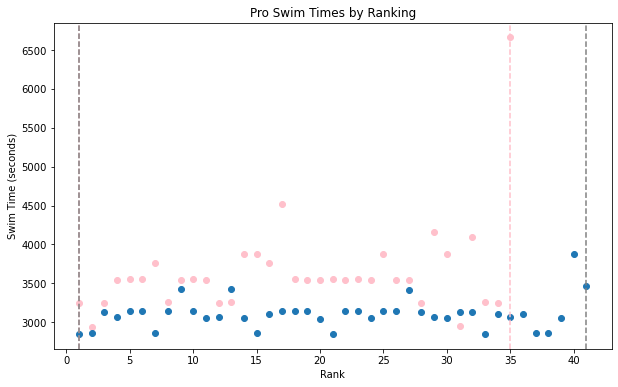

In [12]:
plot_genders_rank('Swim')

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c7dc77fd0>)

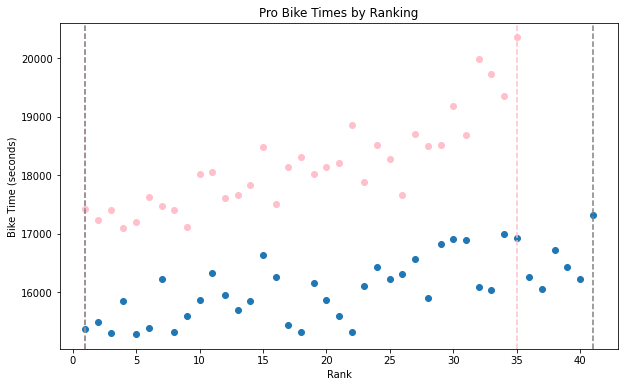

In [13]:
plot_genders_rank('Bike')

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c7dbf6ca0>)

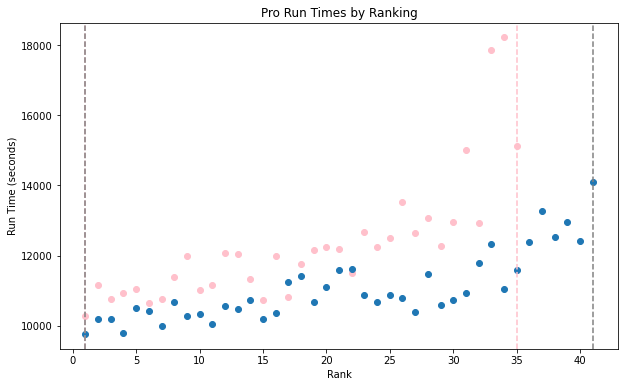

In [14]:
plot_genders_rank('Run')

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c7dbbc760>)

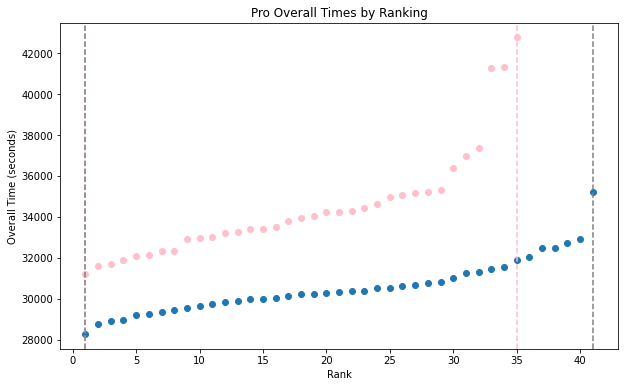

In [15]:
plot_genders_rank('Overall')

# What correlation do event times have with ranking?

In [18]:
import seaborn as sns

## Normalizing data

In [19]:
df['Bool_Gender'] = df['Gender'] == "Female"
df['Bool_Gender'].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
2253    1
2254    0
2255    1
2256    0
2257    0
Name: Bool_Gender, Length: 2256, dtype: int64

In [20]:
def timedelt_tosec(df, col):   
    return df[col].apply(lambda x: x.total_seconds())

In [21]:
df['Swim'] = timedelt_tosec(df, 'Swim')
df['Bike'] = timedelt_tosec(df, 'Bike')
df['Run'] = timedelt_tosec(df, 'Run')
df['Overall'] = timedelt_tosec(df, 'Overall')
df['T1'] = timedelt_tosec(df, 'T1')
df['T2'] = timedelt_tosec(df, 'T2')

In [22]:
heatmap_cols = ['Swim', 'T1', 'Bike', 'T2', 'Run', 'Overall', 'Bool_Gender', 'Division Rank']

In [23]:
heat_df = df[heatmap_cols]

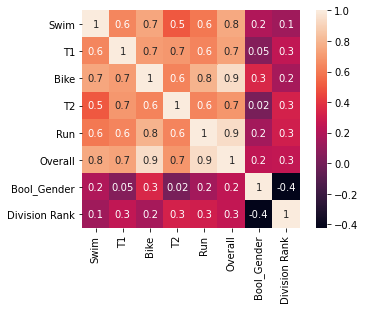

In [24]:
sns.heatmap(heat_df.corr(), annot = True, fmt='.1g', square=True)

Based on the correlation map, we can see that all three events: Swim, Bike, & Run have high correlations with the Overall Time but Swim is slightly less correlated than the other two sports. Run has the greatest correlation of the three events with division rank. Transition times, T1 and T2 have very high correlations with Division Rank! 

I'd like to take a look at just the pros.

<ipython-input-25-d15dfb87c2b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_pros['Bool_Gender'] = (df['Division'] == "FPRO")


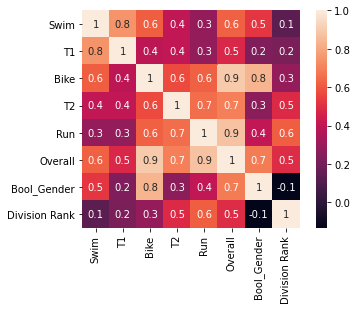

In [25]:
pro_mask = (df['Division'] == 'MPRO') | (df['Division'] == 'FPRO')
heat_pros = df[pro_mask]
heat_pros['Bool_Gender'] = (df['Division'] == "FPRO")
heat_pros['Bool_Gender'].astype(int)
plot = heat_pros[heatmap_cols]
sns.heatmap(plot.corr(), annot = True, fmt='.1g', square=True)

Swim has a much lower correlation in the pro division where Bike and Run times are highly correlated with Overall finish times. I think this has to do with the total distance of the event, 226.31km, and how that's divided amongst the three sports. Swim accounts for 1.7% of the entire race, Bike 79.6%, and Run is 18.7%. Meaning Bike and Run times dominate the Overall time.

Even more interesting is the correlation amongst event times and division rank: T2 and run times have the greatest correlations of all the event times with how pros rank.

Some questions that come up from this heatmap:

Why Run has the greatest correlation (0.6) of the three sports with Division Rank?

What relationship does Gender have with the sports?

-----> *Clean this up*

Assume that pro triathletes competing in Kona are i.i.d. samples of all possible pro triathletes. Computing statistics of this random sample: the sample mean. Since n > 30, Law of Large Numbers is valid and we can assume the distribution of sample means will be approximately normally distributed.

I would like to use the Maximum Likelihood Estimation to find the variance of each sample: Swim, Bike, and Run given the sample means generated by their data.

Steps:
1. Clean data further: Booleans for Gender
2. Isolate np.arrays of each category
3. Scatterplot each!
4. Calculate means for each category
5. Randomly sample from arrays of each category to generate np.arrays of means

Hyp Test: Does a slow or fast Swim time lead to a better Division Rank?

# How many amateurs are racing like pros?

I'm looking to bootstrap the lower 90th percentile of pro event times, and compare those to the bootstrapped 10th percentile of amateur event times.

i.e. if you race x or faster => pro

In [26]:
def times(df, sport):
    '''
    Returns an array of randomly chosen times according to the sport specified.
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    
    Returns:
    np.array of length 2434, with time entries in seconds
    '''
    l = df[sport]
    return np.random.choice(df[sport], size=len(l), replace=True)

In [27]:
def bootstrap_statistic(df, sport, samples, statistic):
    '''
    Returns an array of bootstrapped statistics
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    samples: int: # of samples desired
    statistic: string: statistic to calculate on sample i.e. np.median, np.var, np.std
    '''
    statistics = []
    for i in range(samples):
            samp = times(df, sport)
            statistics.append(statistic(samp))
    return statistics

In [28]:
def bootstrap_percentile(df, sport, samples, percent, statistic=np.percentile):
    statistics = []
    for i in range(samples):
        samp = times(df, sport)
        statistics.append(statistic(samp, percent))
    return statistics

# This is kinda worthless... delete?

In [29]:
bootstrap_swim = bootstrap_statistic(df, 'Swim', 10000, np.median)
bootstrap_bike = bootstrap_statistic(df, 'Bike', 10000, np.median)
bootstrap_run = bootstrap_statistic(df, 'Run', 10000, np.median)

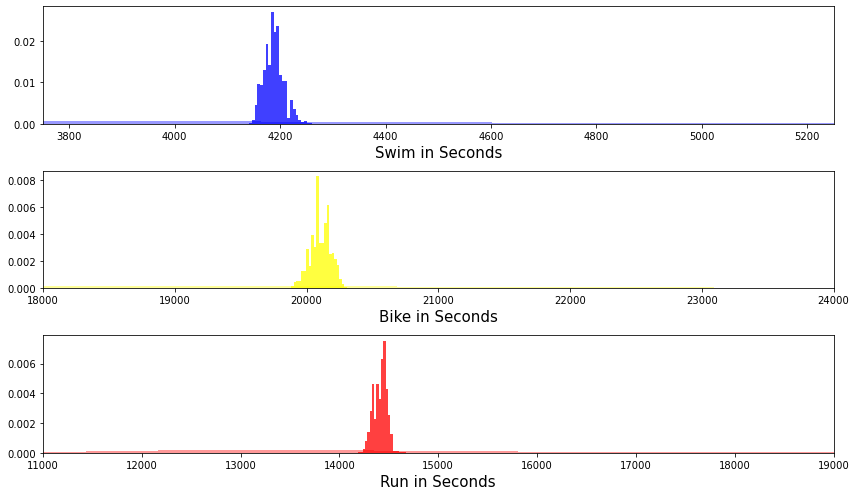

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(12,7))

ax[0].hist(bootstrap_swim, bins=25, density=True, color='blue', alpha=0.75, label='Bootstrap Sample Swim Time Medians')
ax[0].hist(times(df, 'Swim'), bins=25, density=True, color="blue", alpha=0.4, label="Sample Swims")
ax[0].set_xbound(3750,5250)
ax[0].set_xlabel('Swim in Seconds', fontsize=15)

ax[1].hist(bootstrap_bike, bins=25, density=True, color='yellow', alpha=0.75, label='Bootstrap Sample Bike Time Medians')
ax[1].hist(times(df, 'Bike'), bins=25, density=True, color="yellow", alpha=0.4, label="Sample Swims")
ax[1].set_xbound(18000, 24000)
ax[1].set_xlabel('Bike in Seconds', fontsize=15)

ax[2].hist(bootstrap_run, bins=25, density=True, color='red', alpha=0.75, label='Bootstrap Sample Run Time Medians')
ax[2].hist(times(df, 'Run'), bins=25, density=True, color="red", alpha=0.4, label="Sample Runs")
ax[2].set_xbound(11000, 19000)
ax[2].set_xlabel('Run in Seconds', fontsize=15)

plt.tight_layout()

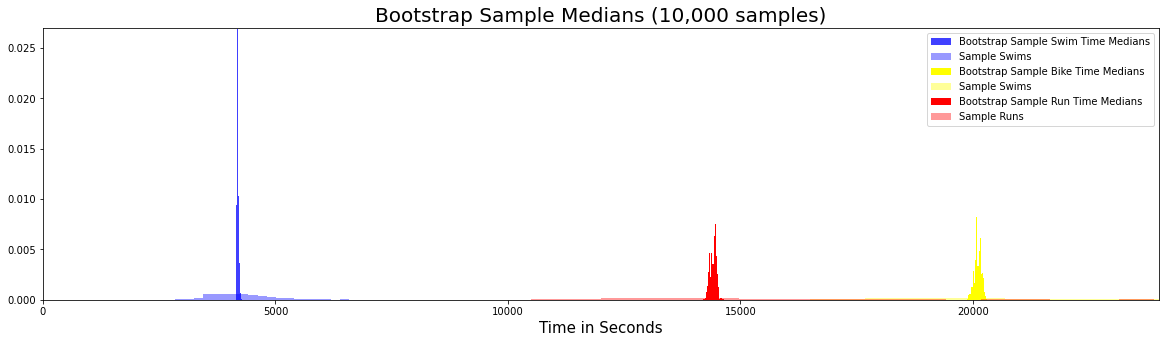

In [31]:
fig,ax = plt.subplots(1, figsize=(20,5))

ax.hist(bootstrap_swim, bins=25, density=True, color='blue', alpha = 0.75, label='Bootstrap Sample Swim Time Medians')
ax.hist(times(df, 'Swim'), bins=25, density=True, color="blue", alpha=0.4, label="Sample Swims")

ax.hist(bootstrap_bike, bins=25, density=True, color='yellow', label='Bootstrap Sample Bike Time Medians')
ax.hist(times(df, 'Bike'), bins=25, density=True, color="yellow", alpha=0.4, label="Sample Swims")

ax.hist(bootstrap_run, bins=25, density=True, color='red', label='Bootstrap Sample Run Time Medians')
ax.hist(times(df, 'Run'), bins=25, density=True, color="red", alpha=0.4, label="Sample Runs")

ax.set_title("Bootstrap Sample Medians (10,000 samples)", fontsize = 20)
ax.set_xlabel('Time in Seconds', fontsize=15)
ax.set_xbound(0, 24000)
ax.set_ybound(0, .027)
ax.legend()

# (still worthless) To test for how fast a Swim, Bike, or Run time qualifies you as a "pro", I will bootstrap from the pros only.

Then I will test fast Division times against a p-value generated from the pro's medians.

First, Female Pros:

In [32]:
fem_pro = df[df['Division'] == 'FPRO']

In [33]:
bootstrap_fpro_swim = bootstrap_statistic(fem_pro, 'Swim', 1000, np.median)

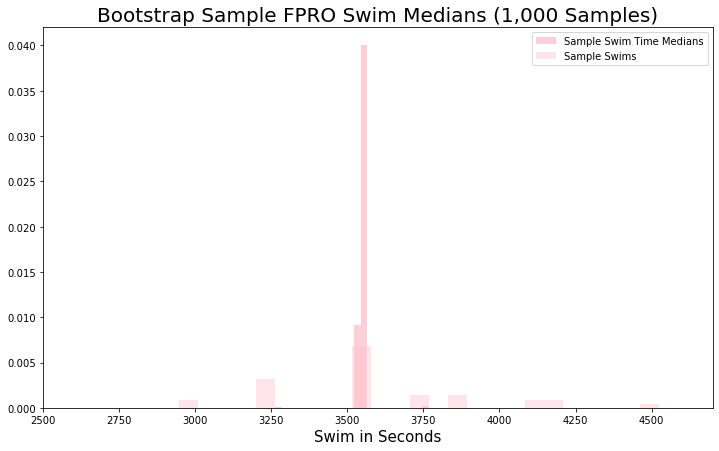

In [34]:
fig, ax = plt.subplots(1, figsize=(12,7))

ax.hist(bootstrap_fpro_swim, bins=25, density=True, color='pink', alpha=0.75, label='Sample Swim Time Medians')
ax.hist(times(fem_pro, 'Swim'), bins=25, density=True, color="pink", alpha=0.4, label="Sample Swims")
ax.set_title('Bootstrap Sample FPRO Swim Medians (1,000 Samples)', fontsize=20)
ax.set_xbound(2500, 4700)
ax.set_xlabel('Swim in Seconds', fontsize=15)
ax.legend()

In [35]:
std_samp = np.std(times(fem_pro, 'Swim'))
std_b_medians = np.std(bootstrap_fpro_swim)
print(f'Standard Deviation of Sample (minutes): {round(std_samp/60, 2)} and standard deviation of sample medians (minutes): {round(std_b_medians/60,2)}')


Standard Deviation of Sample (minutes): 14.89 and standard deviation of sample medians (minutes): 0.34


In [36]:
fem_pro_p = bootstrap_percentile(fem_pro, 'Swim', 1000, 75)

In [37]:
left = np.percentile(fem_pro_p, 2.5)
right = np.percentile(fem_pro_p, 97.5)
print(f'Bootstrap Confidence Interval for Population 75th Percentile (minutes): [{round(left/60, 2)}, {round(right/60,2)}]')

Bootstrap Confidence Interval for Population 75th Percentile (minutes): [59.2, 64.62]


Text(0.5, 0, 'Swim in Seconds')

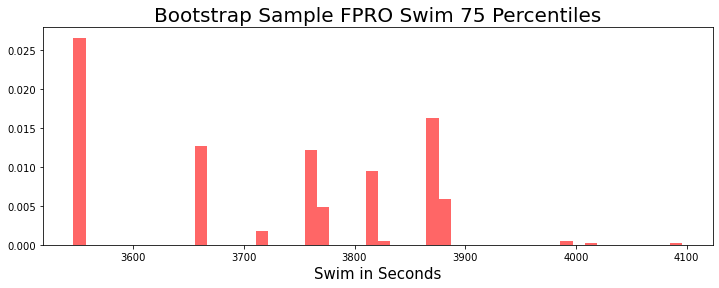

In [38]:
fig, ax = plt.subplots(1, figsize=(12,4))

ax.hist(fem_pro_p, bins=50, density=True, color='r', alpha=0.6)
ax.set_title('Bootstrap Sample FPRO Swim 75 Percentiles', fontsize=20)
ax.set_xlabel('Swim in Seconds', fontsize=15)

In [39]:
male_pro = df[df['Division'] == 'MPRO']
bootstrap_mpro_swim = bootstrap_statistic(male_pro, 'Swim', 1000, np.median)

Text(0.5, 0, 'Swim in Seconds')

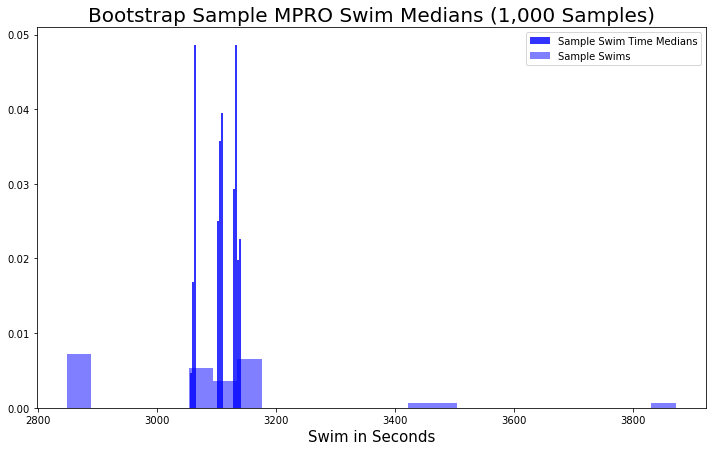

In [40]:
fig, ax = plt.subplots(1, figsize=(12,7))

ax.hist(bootstrap_mpro_swim, bins=25, density=True, color='blue', alpha=0.8, label='Sample Swim Time Medians')
ax.hist(times(male_pro, 'Swim'), bins=25, density=True, color="blue", alpha=0.5, label="Sample Swims")
ax.set_title('Bootstrap Sample MPRO Swim Medians (1,000 Samples)', fontsize=20)
ax.legend()
ax.set_xlabel('Swim in Seconds', fontsize=15)

In [41]:
male_pro_p = bootstrap_percentile(male_pro, 'Swim', 1000, 75)

In [42]:
left = np.percentile(male_pro_p, 2.5)
right = np.percentile(male_pro_p, 97.5)
# 95 % Confident that this is our 75th Percentile
print(f'Bootstrap Confidence Interval for Population 75th Percentile (minutes): [{round(left/60, 2)}, {round(right/60,2)}]')

Bootstrap Confidence Interval for Population 75th Percentile (minutes): [52.28, 52.48]


Text(0.5, 0, 'Swim in Seconds')

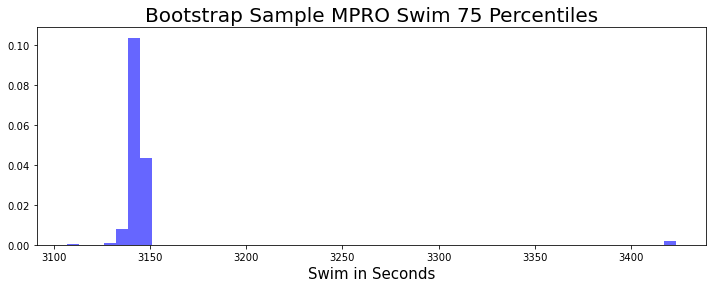

In [43]:
fig, ax = plt.subplots(1, figsize=(12,4))

ax.hist(male_pro_p, bins=50, density=True, color='b', alpha=0.6)
ax.set_title('Bootstrap Sample MPRO Swim 75 Percentiles', fontsize=20)
ax.set_xlabel('Swim in Seconds', fontsize=15)

# ...end worthless section

# Let's look at the "slower" pros:

In [44]:
def plot_pro_90(sport, df1=fem_pro, df2=male_pro):
    # Generate bootstrap 90th percentiles
    fem_90p = bootstrap_percentile(df1, sport, 1000, 90)
    male_90p = bootstrap_percentile(df2, sport, 1000, 90)
    
    # Say it with confidence
    left_f90p = np.percentile(fem_90p, 2.5)
    right_f90p = np.percentile(fem_90p, 97.5)

    left_m90p = np.percentile(male_90p, 2.5)
    right_m90p = np.percentile(male_90p, 97.5)
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    ax.hist(fem_90p, bins=50, density=True, color='pink', alpha=0.8, label=f'Female Pro {sport} 90th Percentile')
    ax.hist(male_90p, bins=50, density=True, color='b', alpha=0.7, label=f'Male Pro {sport} 90th Percentile')
    ax.legend()

    ax.set_title(f'Pro {sport} 90th Percentiles', fontsize=20)
    ax.set_xlabel(f'{sport} Time (seconds)', fontsize=15)

    ax.axvline(left_f90p, c='pink', linestyle="--")
    ax.axvline(right_f90p, c='pink', linestyle="--")
    ax.axvline(left_m90p, c='grey', linestyle="--")
    ax.axvline(right_m90p, c='grey', linestyle="--")
    
    print(f'Female Pro {sport} Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [{round(left_f90p/60, 2)}, {round(right_f90p/60,2)}]')
    print(f'Male Pro {sport} Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [{round(left_m90p/60, 2)}, {round(right_m90p/60,2)}]')

    return fig, ax

Female Pro Swim Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [62.77, 75.4]
Male Pro Swim Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [52.38, 57.83]


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c75faf280>)

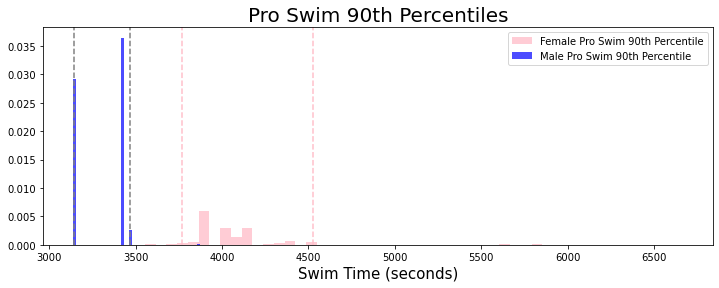

In [45]:
plot_pro_90('Swim')

In effort to answer the question, how fast do you need to swim to be considered a pro? We can see our 95% confidence interval for the 10th percentile of Female and Male Pro swim times. Therefore, if you swim in, or faster than this 10th percentile, I am 95% confident you are considered a pro swimming triathlete!

Female Pro Bike Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [310.01, 333.25]
Male Pro Bike Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [273.95, 283.17]


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c7c564520>)

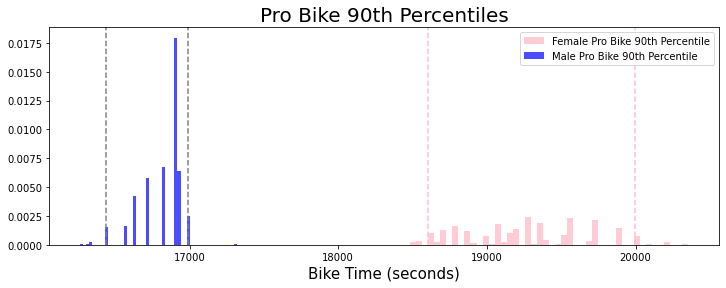

In [46]:
plot_pro_90('Bike')

Female Pro Run Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [211.4, 297.6]
Male Pro Run Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [193.0, 221.37]


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c75e0abe0>)

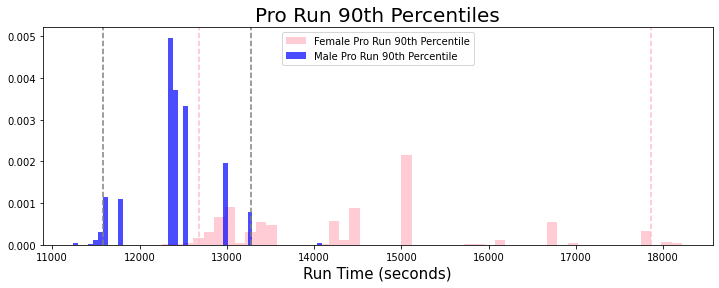

In [47]:
plot_pro_90('Run')

Something to keep in mind is that to be considered pro, you would need to compete in this percentile range (or faster) and have done all triathlon activities in the same order: swim-bike-run.

Female Pro Overall Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [586.45, 688.37]
Male Pro Overall Times Bootstrap Confidence Interval for Population 90th Percentile (minutes): [521.32, 548.9]


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c75cc76a0>)

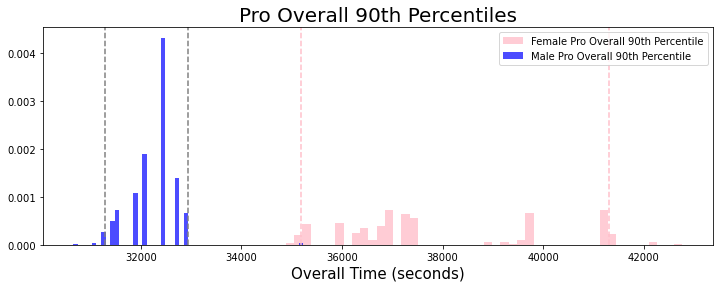

In [48]:
plot_pro_90('Overall')

# Let's look at the amateur times with the pro times 95% confidence intervals

In [49]:
def plot_amateur_proci(sport, df1=fem_agegroups, df2=male_agegroups, df3=fem_pro, df4=male_pro):
    # Convert Amateur times to minutes
    f_agegroups_ = (timedelt_tosec(df1, sport)) / 60
    m_agegroups_ = (timedelt_tosec(df2, sport)) / 60

    # Generate pro bootstrap 90th percentiles
    fem_90p = bootstrap_percentile(df3, sport, 1000, 90)
    male_90p = bootstrap_percentile(df4, sport, 1000, 90)
    
    # Say it with confidence
    left_f90p = np.percentile(fem_90p, 2.5)
    right_f90p = np.percentile(fem_90p, 97.5)

    left_m90p = np.percentile(male_90p, 2.5)
    right_m90p = np.percentile(male_90p, 97.5)
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    
    ax.hist(m_agegroups_, bins=100, density=True, color='grey', alpha=0.75, label=f'Male Amateur {sport} Times')
    ax.hist(f_agegroups_, bins=100, density=True, color='pink', alpha=0.75, label=f'Female Amateur {sport} Times')
    ax.axvline(left_f90p/60, c='red', linestyle="--", label='Female Pro 90 Percentile')
    ax.axvline(right_f90p/60, c='red', linestyle="--")
    ax.axvline(left_m90p/60, c='black', linestyle="--", label='Male Pro 90 Percentile')
    ax.axvline(right_m90p/60, c='black', linestyle="--")
    ax.legend()

    ax.set_title(f'How do Amateurs Compare to the Pro {sport} 90th Percentile?', fontsize=20)
    ax.set_xlabel(f'{sport} Time (minutes)', fontsize=15)
    
    m_ = m_agegroups_[m_agegroups_ <= right_m90p/60]
    f_ = f_agegroups_[f_agegroups_ <= right_f90p/60]
    mam_pros_ = round((len(m_) / len(m_agegroups_))*100, 2)
    fam_pros_ = round((len(f_) / len(f_agegroups_))*100, 2)
    print(f'Percent of male amateurs who {sport} like pros: {mam_pros_}%')
    print(f'Percent of female amateurs who {sport} like pros: {fam_pros_}%')

    return fig, ax

Percent of male amateurs who Swim like pros: 8.28%
Percent of female amateurs who Swim like pros: 48.52%


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c75c79d30>)

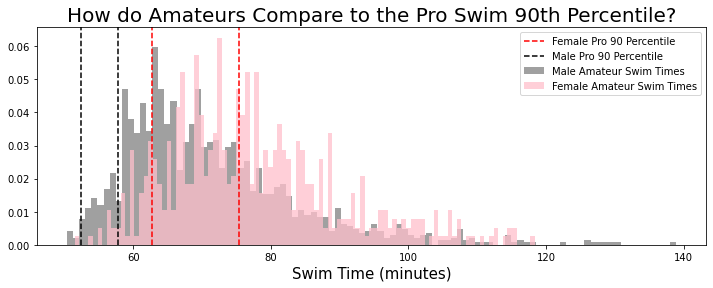

In [50]:
plot_amateur_proci('Swim')

Percent of male amateurs who Bike like pros: 1.74%
Percent of female amateurs who Bike like pros: 11.69%


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c75fdb820>)

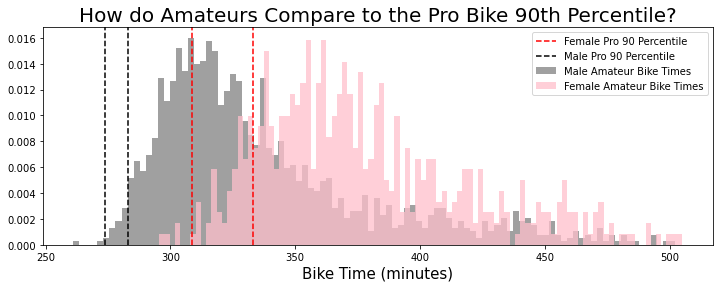

In [51]:
plot_amateur_proci('Bike')

Percent of male amateurs who Run like pros: 37.09%
Percent of female amateurs who Run like pros: 72.43%


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c75cf67f0>)

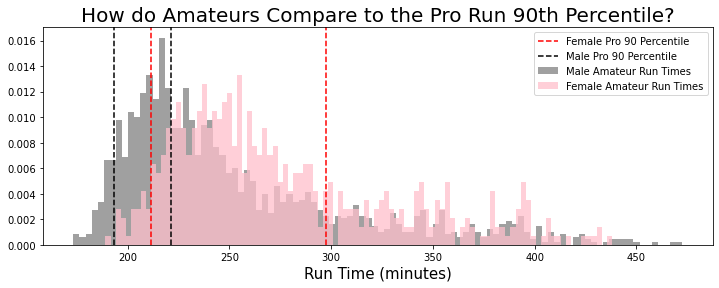

In [52]:
plot_amateur_proci('Run')

We can see from our original female pro run times, that 3-4 female pro runners were much slower than the majority of the female pro runners, bringing their 90th percentile further right. Which is why the percent of female amateurs who run like these pros is so high.

Percent of male amateurs who Overall like pros: 2.74%
Percent of female amateurs who Overall like pros: 36.47%


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c752588e0>)

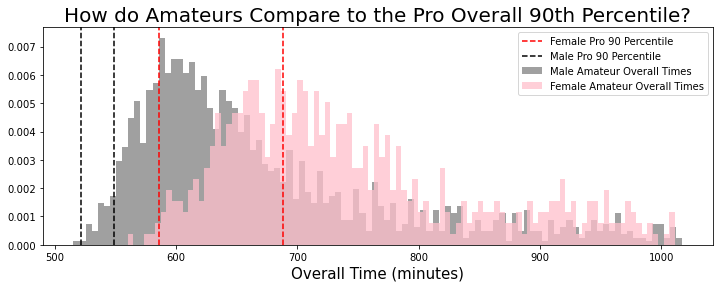

In [53]:
plot_amateur_proci('Overall')

# Better: Bootstrap 10th percentile of amateur times and compare to pro's 90th percentile

In [54]:
'''
scrap
    
    m_ = male_10[male_10 <= right_m90]
    f_ = fem_10[fem_10 <= right_f90]
    mam_pros_ = round((len(m_) / len(male_10))*100, 2)
    fam_pros_ = round((len(f_) / len(fem_10))*100, 2)
    print(f'Percent of male 10 percentile amateurs who {sport} like 90 percentile pros: {mam_pros_}%')
    print(f'Percent of female 10 percentile amateurs who {sport} like 90 percentile pros: {fam_pros_}%')
'''

"\nscrap\n    \n    m_ = male_10[male_10 <= right_m90]\n    f_ = fem_10[fem_10 <= right_f90]\n    mam_pros_ = round((len(m_) / len(male_10))*100, 2)\n    fam_pros_ = round((len(f_) / len(fem_10))*100, 2)\n    print(f'Percent of male 10 percentile amateurs who {sport} like 90 percentile pros: {mam_pros_}%')\n    print(f'Percent of female 10 percentile amateurs who {sport} like 90 percentile pros: {fam_pros_}%')\n"

In [55]:
def plot_cis(sport, df1=fem_agegroups, df2=male_agegroups, df3=fem_pro, df4=male_pro):
    # Convert amateur times to minutes
    df1[sport] = (timedelt_tosec(df1, sport)) / 60
    df2[sport] = (timedelt_tosec(df2, sport)) / 60
    
    # Bootstrap amateur 10th percentiles
    fem_10 = bootstrap_percentile(df1, sport, 1000, 10)
    male_10 = bootstrap_percentile(df2, sport, 1000, 10)
    
    # Say it with confidence
    left_f10 = np.percentile(fem_10, 2.5)
    right_f10 = np.percentile(fem_10, 97.5)
    left_m10 = np.percentile(male_10, 2.5)
    right_m10 = np.percentile(male_10, 97.5)
    
    # Generate pro bootstrap 90th percentiles
    fem_90 = bootstrap_percentile(df3, sport, 1000, 90)
    male_90 = bootstrap_percentile(df4, sport, 1000, 90)
    
    # Say it with confidence
    left_f90 = np.percentile(fem_90, 2.5)
    right_f90 = np.percentile(fem_90, 97.5)
    left_m90 = np.percentile(male_90, 2.5)
    right_m90 = np.percentile(male_90, 97.5)
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    
    ax.hist(male_10, bins=100, density=True, color='grey', alpha=0.75, label=f'Male Amateur {sport} 10 Percentiles')
    ax.hist(fem_10, bins=100, density=True, color='pink', alpha=0.75, label=f'Female Amateur {sport} 10 Percentiles')
    ax.axvline(left_f90/60, c='red', linestyle="--", label='Female Pro 90 Percentile')
    ax.axvline(right_f90/60, c='red', linestyle="--")
    ax.axvline(left_m90/60, c='black', linestyle="--", label='Male Pro 90 Percentile')
    ax.axvline(right_m90/60, c='black', linestyle="--")
    ax.legend()

    ax.set_title(f'How does the {sport} Amateur 10th Percentile Compare to the Pro 90th Percentile?', fontsize=20)
    ax.set_xlabel(f'{sport} Time (minutes)', fontsize=15)

    return fig, ax

<ipython-input-55-80847a5a653c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[sport] = (timedelt_tosec(df1, sport)) / 60
<ipython-input-55-80847a5a653c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[sport] = (timedelt_tosec(df2, sport)) / 60


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c750a7310>)

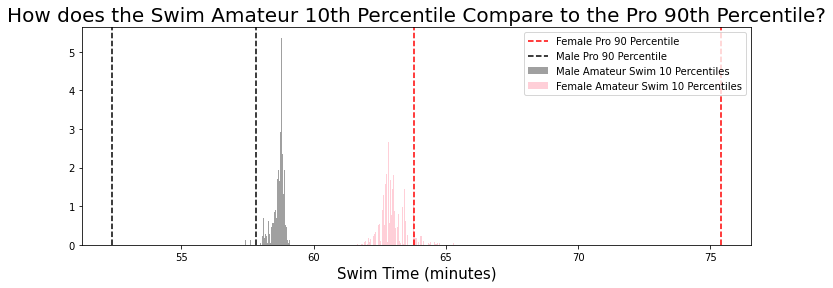

In [56]:
plot_cis('Swim')

<ipython-input-55-80847a5a653c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[sport] = (timedelt_tosec(df1, sport)) / 60
<ipython-input-55-80847a5a653c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[sport] = (timedelt_tosec(df2, sport)) / 60


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c75084a00>)

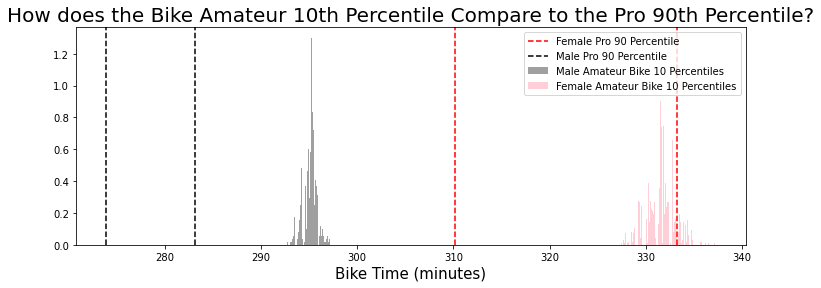

In [57]:
plot_cis('Bike')

<ipython-input-55-80847a5a653c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[sport] = (timedelt_tosec(df1, sport)) / 60
<ipython-input-55-80847a5a653c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[sport] = (timedelt_tosec(df2, sport)) / 60


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c74ebf9a0>)

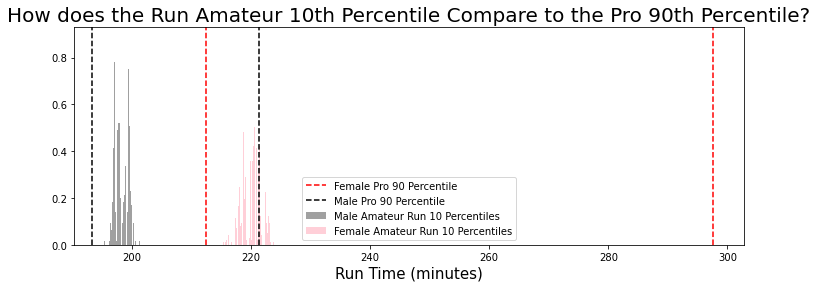

In [58]:
plot_cis('Run')

<ipython-input-55-80847a5a653c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[sport] = (timedelt_tosec(df1, sport)) / 60
<ipython-input-55-80847a5a653c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[sport] = (timedelt_tosec(df2, sport)) / 60


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c74729d60>)

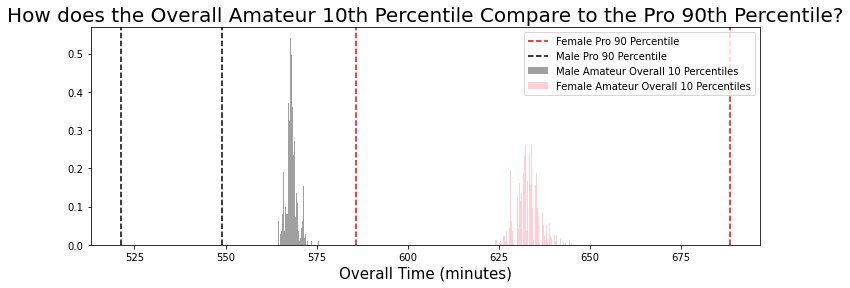

In [59]:
plot_cis('Overall')

This shows me I need to go back and clean out the female pro that is weighing down the values.

# Next Compare to Division Ranks